In [1]:
import numpy as np
def merge_batch_files(batch_files, output_npz, param_names):
    """合并所有批次文件"""
    all_hitsE = []
    all_hitsM = []
    all_params = []

    for batch_file in batch_files:
        data = np.load(batch_file, allow_pickle=True)
        all_hitsE.extend(data["hitsE"])
        all_hitsM.extend(data["hitsM"])
        all_params.extend(data["params"])

    np.savez_compressed(output_npz,
                        hitsE=np.array(all_hitsE, dtype=object),
                        hitsM=np.array(all_hitsM, dtype=object),
                        params=np.array(all_params, dtype=object),
                        param_names=param_names)
    print(f"All data saved to: {output_npz}")

def sample_data(file_path, output_npz, batch_size=(-1, 1000, 1000)):
    """
    从合并后的 npz 文件中随机抽样指定数量的 monopole、gamma、proton 事件。
    
    参数：
        file_path: str
            输入 npz 文件路径（由 merge_batch_files 生成的最终文件）
        output_npz: str
            输出抽样 npz 文件路径
        batch_size: tuple
            (n_monopole, n_gamma, n_proton)
            若为 -1 则表示使用该类的全部样本
    """
    data = np.load(file_path, allow_pickle=True)
    hitsE_all, hitsM_all, params_all, param_names = (
        data["hitsE"], data["hitsM"], data["params"], data["param_names"]
    )

    params_all = np.array(params_all, dtype=object)
    labels = np.array([p[0] for p in params_all])  # label 是 params 的第一个元素

    # 定义类别映射
    label_map = {
        43: ("monopole", batch_size[0]),
        1:  ("gamma", batch_size[1]),
        14: ("proton", batch_size[2])
    }

    selected_hitsE, selected_hitsM, selected_params = [], [], []

    for label_value, (label_name, n_sample) in label_map.items():
        idx = np.where(labels == label_value)[0]
        total = len(idx)
        if total == 0:
            print(f"[WARN] No samples found for label={label_value} ({label_name})")
            continue

        if n_sample == -1 or n_sample > total:
            n_sample = total

        chosen = np.random.choice(idx, size=n_sample, replace=False)
        print(f"[INFO] Selected {n_sample}/{total} {label_name} events")

        selected_hitsE.extend(hitsE_all[chosen])
        selected_hitsM.extend(hitsM_all[chosen])
        selected_params.extend(params_all[chosen])

    np.savez_compressed(
        output_npz,
        hitsE=np.array(selected_hitsE, dtype=object),
        hitsM=np.array(selected_hitsM, dtype=object),
        params=np.array(selected_params, dtype=object),
        param_names=param_names
    )

    print(f"[DONE] Saved sampled dataset to: {output_npz}")

npzfile_list=[
#                 "/home/zhonghua/data/Dataset_Filted/1e10_V03/Gamma_combined_filted_1e10_V03_12_13_dataset.npz",
#                 "/home/zhonghua/data/Dataset_Filted/1e10_V03/Gamma_combined_filted_1e10_V03_13_14_dataset.npz",
#                 "/home/zhonghua/data/Dataset_Filted/1e10_V03/Gamma_combined_filted_1e10_V03_14_15_dataset.npz",
#                 "/home/zhonghua/data/Dataset_Filted/1e10_V03/Gamma_combined_filted_1e10_V03_15_16_dataset.npz",
                "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_combined_filted_1e10_V03_12_13_dataset.npz",
                "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_combined_filted_1e10_V03_13_14_dataset.npz",
                "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_combined_filted_1e10_V03_14_15_dataset.npz",
                "/home/zhonghua/data/Dataset_Filted/1e10_V03/Proton_combined_filted_1e10_V03_15_16_dataset.npz",
                "/home/zhonghua/data/Dataset_Filted/1e10_V03/Monopole_combined_filted_1e10_V03_dataset.npz",
                ]
param_names=["label","weight",
                "R_ue", "R_mean", "Eage", "trueE", "recE", "rec_x", "rec_y", "rec_theta", "rec_phi"]

allnpzfile="/home/zhonghua/data/Dataset_Filted/1e10_V03/all_combined_filted_1e10_V03_dataset.npz"
merge_batch_files(npzfile_list,allnpzfile , param_names)


sampledfile="/home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset.npz"
sample_data(allnpzfile, sampledfile, batch_size=(-1,0, 120000))  # monopole , gamma , proton


All data saved to: /home/zhonghua/data/Dataset_Filted/1e10_V03/all_combined_filted_1e10_V03_dataset.npz
[INFO] Selected 17944/17944 monopole events
[WARN] No samples found for label=1 (gamma)
[INFO] Selected 120000/163783 proton events
[DONE] Saved sampled dataset to: /home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset.npz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def filter_dataset(npz_file, output_file):
    ############################################################################
    
    data= np.load(npz_file, allow_pickle=True)
    params = data["params"]
    print(data["param_names"])
    params=data["params"]
    exp_num=np.sum(params[:,0]==-1)
    pr_num=np.sum(params[:,0]==14)
    ga_num=np.sum(params[:,0]==1)
    mn_num=np.sum(params[:,0]==43)
    print(f"Experiment num: {exp_num}")
    print(f"Proton num: {pr_num}")
    print(f"Gamma num: {ga_num}")
    print(f"Monopole num: {mn_num}")
    new_indices=[]
    rs=[]
    for n in range(len(data["params"])):
        R_ue=params[n][2]
        R_mean=params[n][3]
        Eage=params[n][4]
        r= np.sqrt(params[n][-3]**2 + params[n][-4]**2)
        rs.append(r)
        if (R_mean>20.0) and (R_mean<50.0) and (Eage>0.8) and (Eage<1.2) and (r>250) and (r<550): 
            new_indices.append(n)

    # print(f"max r = {max(rs)}, index={rs.index(max(rs))}, param={params[rs.index(max(rs))]}")
    # 保存筛选后的数据到新文件
    

    # 获取所有数组的键名
    keys = data.files

    # 创建字典来存储筛选后的数据
    filtered_data = {}

    for key in keys:
        if key == "param_names":  # 对于参数名称，直接保留
            filtered_data[key] = data[key]
        else:  # 对于其他数组，根据筛选的索引提取数据
            filtered_data[key] = data[key][new_indices]

    # 保存到新文件
    np.savez(output_file, **filtered_data)

    print(f"筛选后的数据已保存到: {output_file}")
    print(f"原始数据量: {len(data['params'])}")
    print(f"筛选后数据量: {len(new_indices)}")

    # 验证保存的文件
    new_data = np.load(output_file, allow_pickle=True)
    print(f"验证 - 新文件中的数据量: {len(new_data['params'])}")
    new_params = new_data["params"]
    exp_num=np.sum(new_params[:,0]==-1)
    pr_num=np.sum(new_params[:,0]==14)
    ga_num=np.sum(new_params[:,0]==1)
    mn_num=np.sum(new_params[:,0]==43)
    print(f"Experiment num: {exp_num}")
    print(f"Proton num: {pr_num}")
    print(f"Gamma num: {ga_num}")
    print(f"Monopole num: {mn_num}")
    # 关闭文件
    data.close()
    new_data.close()

npz_file = "/home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset.npz"
output_file = "/home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset_optimized.npz"
filter_dataset(npz_file, output_file)
print()
npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset.npz"
output_file = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset_optimized.npz"
filter_dataset(npz_file, output_file)


['label' 'weight' 'R_ue' 'R_mean' 'Eage' 'trueE' 'recE' 'rec_x' 'rec_y'
 'rec_theta' 'rec_phi']
Experiment num: 0
Proton num: 120000
Gamma num: 0
Monopole num: 17944
筛选后的数据已保存到: /home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset_optimized.npz
原始数据量: 137944
筛选后数据量: 33094
验证 - 新文件中的数据量: 33094
Experiment num: 0
Proton num: 20623
Gamma num: 0
Monopole num: 12471

['label' 'weight' 'R_ue' 'R_mean' 'Eage' 'trueE' 'recE' 'rec_x' 'rec_y'
 'rec_theta' 'rec_phi']
Experiment num: 5234
Proton num: 0
Gamma num: 0
Monopole num: 0
筛选后的数据已保存到: /home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset_optimized.npz
原始数据量: 5234
筛选后数据量: 1634
验证 - 新文件中的数据量: 1634
Experiment num: 1634
Proton num: 0
Gamma num: 0
Monopole num: 0


In [ ]:
2702*12


32424

In [1]:
# 分析实验数据异常
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
MC_data = np.load("/home/zhonghua/data/Dataset_Filted/1e10_V03/all_combined_filted_1e10_V03_dataset.npz", allow_pickle=True)
MC_hitsE = MC_data["hitsE"]
MC_hitsM = MC_data["hitsM"]
MC_params = MC_data["params"]
MC_params = np.array(MC_params, dtype=float)
param_names=MC_data["param_names"]

pr_indices=np.where(MC_params[:,0]==14)
pr_params=np.array(MC_params[pr_indices],dtype=float)

ga_indices=np.where(MC_params[:,0]==1)
ga_params=np.array(MC_params[ga_indices],dtype=float)

mn_indices=np.where(MC_params[:,0]==43)
mn_params=np.array(MC_params[mn_indices],dtype=float)

print(param_names)



['label' 'weight' 'R_ue' 'R_mean' 'Eage' 'trueE' 'recE' 'rec_x' 'rec_y'
 'rec_theta' 'rec_phi']


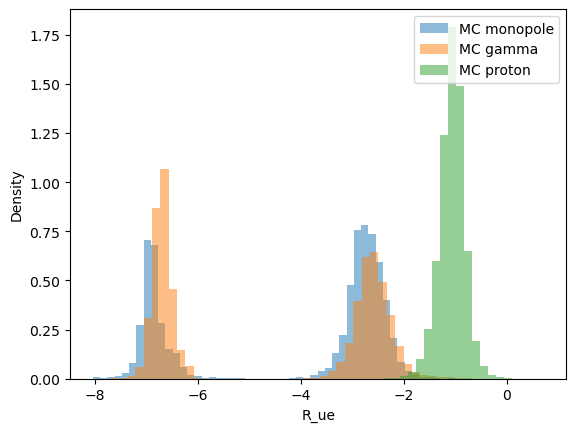

Proton ratio: 0.000146535354707143
Gamma ratio: 0.7454751794433696
Monopole ratio: 0.7658716031802539


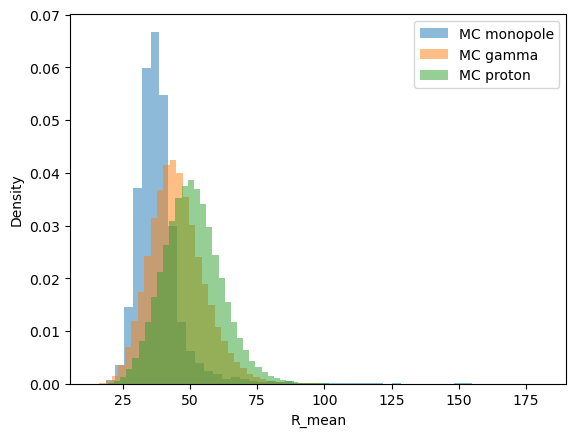

Proton ratio: 0.477980010135362
Gamma ratio: 0.700185096777976
Monopole ratio: 0.9246469680787943


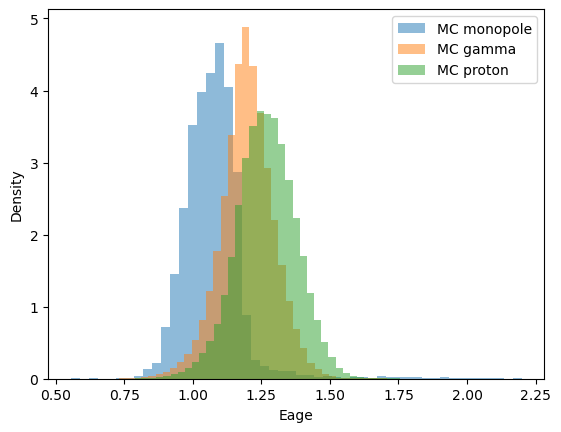

Proton ratio: 0.25588125751756896
Gamma ratio: 0.507491813027128
Monopole ratio: 0.9519401922392311


In [ ]:
col=2
plt.hist(mn_params[:, col], bins=50, alpha=0.5, density=True, label="MC monopole")
plt.hist(ga_params[:, col], bins=50, alpha=0.5, density=True, label="MC gamma")
plt.hist(pr_params[:, col], bins=50, alpha=0.5, density=True, label="MC proton")
plt.xlabel(f"{param_names[col]}")
plt.legend(loc='upper right')
plt.ylabel("Density")
plt.show()

down=-np.inf
up=-2.6
pr_ratio=(np.sum((pr_params[:, col]<up) & (pr_params[:, col]>down)))/len(pr_params[:, col])
ga_ratio=(np.sum((ga_params[:, col]<up) & (ga_params[:, col]>down)))/len(ga_params[:, col])
mn_ratio=(np.sum((mn_params[:, col]<up) & (mn_params[:, col]>down)))/len(mn_params[:, col])
print(f"Proton ratio: {pr_ratio}")
print(f"Gamma ratio: {ga_ratio}")
print(f"Monopole ratio: {mn_ratio}")

col=3
plt.hist(mn_params[:, col], bins=50, alpha=0.5, density=True, label="MC monopole")
plt.hist(ga_params[:, col], bins=50, alpha=0.5, density=True, label="MC gamma")
plt.hist(pr_params[:, col], bins=50, alpha=0.5, density=True, label="MC proton")
plt.xlabel(f"{param_names[col]}")
plt.legend(loc='upper right')
plt.ylabel("Density")
plt.show()

down=25
up=50
col=3
pr_ratio=(np.sum((pr_params[:, col]<up) & (pr_params[:, col]>down)))/len(pr_params[:, col])
ga_ratio=(np.sum((ga_params[:, col]<up) & (ga_params[:, col]>down)))/len(ga_params[:, col])
mn_ratio=(np.sum((mn_params[:, col]<up) & (mn_params[:, col]>down)))/len(mn_params[:, col])
print(f"Proton ratio: {pr_ratio}")
print(f"Gamma ratio: {ga_ratio}")
print(f"Monopole ratio: {mn_ratio}")


col=4
plt.hist(mn_params[:, col], bins=50, alpha=0.5, density=True, label="MC monopole")
plt.hist(ga_params[:, col], bins=50, alpha=0.5, density=True, label="MC gamma")
plt.hist(pr_params[:, col], bins=50, alpha=0.5, density=True, label="MC proton")
plt.xlabel(f"{param_names[col]}")
plt.legend(loc='upper right')
plt.ylabel("Density")
plt.show()

down=0.8
up=1.2
col=4
pr_ratio=(np.sum((pr_params[:, col]<up) & (pr_params[:, col]>down)))/len(pr_params[:, col])
ga_ratio=(np.sum((ga_params[:, col]<up) & (ga_params[:, col]>down)))/len(ga_params[:, col])
mn_ratio=(np.sum((mn_params[:, col]<up) & (mn_params[:, col]>down)))/len(mn_params[:, col])
print(f"Proton ratio: {pr_ratio}")
print(f"Gamma ratio: {ga_ratio}")
print(f"Monopole ratio: {mn_ratio}")


In [11]:
pr_num=(2.18E+10*4.89E-03+1.23E+09*1.80E-01)*1.4e-4*0.45
mn_num=800*0.95*0.768*3360/3572
print(f"Estimated proton count: {pr_num*pr_ratio}")
print(f"Estimated monopole count: {mn_num*mn_ratio}")



Estimated proton count: 9471.05775
Estimated monopole count: 502.7605113767482


In [10]:
up0 = -2.6
col0 = 2

# 第一个筛选条件 (col=3, 范围 25-50)
down1 = 25
up1 = 50
col1 = 3

# 第二个筛选条件 (col=4, 范围 0.8-1.2)
down2 = 0.8
up2 = 1.2
col2 = 4
pr_params=np.array(pr_params,dtype=float)[(pr_params[:, col0] < up0)]
ga_params=np.array(ga_params,dtype=float)[(ga_params[:, col0] < up0)]
mn_params=np.array(mn_params,dtype=float)[(mn_params[:, col0] < up0)]

pr_ratio = (np.sum((pr_params[:, col1] < up1) & (pr_params[:, col1] > down1) & 
                   (pr_params[:, col2] < up2) & (pr_params[:, col2] > down2))) / len(pr_params[:, col1])

ga_ratio = (np.sum((ga_params[:, col1] < up1) & (ga_params[:, col1] > down1) & 
                   (ga_params[:, col2] < up2) & (ga_params[:, col2] > down2))) / len(ga_params[:, col1])

mn_ratio = (np.sum((mn_params[:, col1] < up1) & (mn_params[:, col1] > down1) & 
                   (mn_params[:, col2] < up2) & (mn_params[:, col2] > down2))) / len(mn_params[:, col1])

print(f"Proton ratio: {pr_ratio}")
print(f"Gamma ratio: {ga_ratio}")
print(f"Monopole ratio: {mn_ratio}")


Proton ratio: 0.4583333333333333
Gamma ratio: 0.4773867370727186
Monopole ratio: 0.9157111868608615


[-1 1 -6.471570037337265 42.941285717798394 1.1512045860290527 -1.0
 1.9676754474639893 -592.833984375 15.813830375671387 0.47368597984313965
 3.230376958847046]
399
103


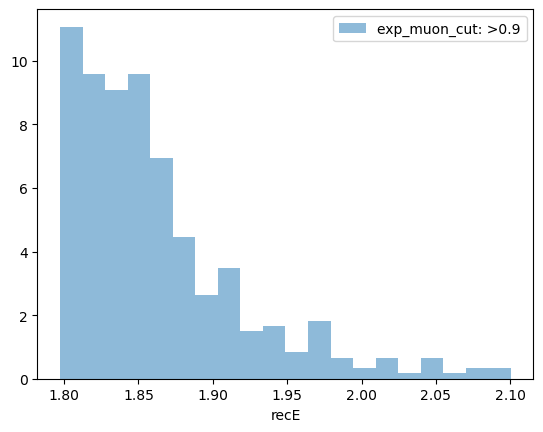

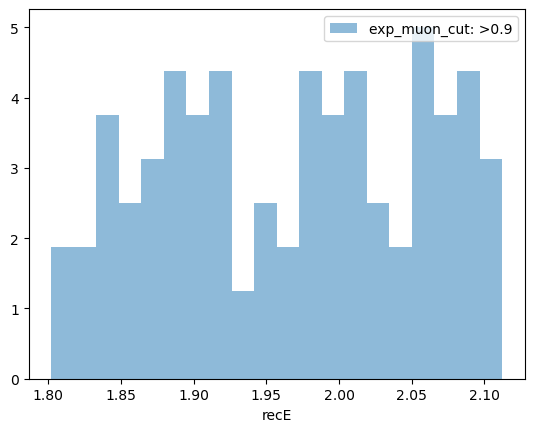

In [9]:
ED_pos_file="/home/zhonghua/Filt_Event/config/ED_pos_5216up_20210807.txt"
MD_pos_file="/home/zhonghua/Filt_Event/config/MD_pos_1188.txt"
positions_ED= pd.read_csv(ED_pos_file,  sep=r'\s+', skiprows=1, header=None, names=["id","x","y","z"])
positions_MD= pd.read_csv(MD_pos_file,  sep=r'\s+', skiprows=1, header=None, names=["id","x","y","z"])


exp_npzfile="/home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset_optimized.npz" 
exp_data = np.load(exp_npzfile, allow_pickle=True)
exp_hitsE = exp_data["hitsE"]
exp_hitsM = exp_data["hitsM"]
exp_params = exp_data["params"]
print(exp_params[1])
exp_param_names=exp_data["param_names"]

probs_data = np.load("/home/zhonghua/Filt_Event/transformer/1e10_Ponly_optimized/exp_probs_optimized.npz", allow_pickle=True)
probs = probs_data["probs"]
indices = probs_data["indices"]
new_indices=[]
for n in range(len(exp_params)):
    prob=probs[n]
    if (prob<0.05):
        new_indices.append(n)
print(len(new_indices))

new_indices_1=[]
for n in range(len(exp_params)):
    prob=probs[n]
    if (prob>0.5):
        new_indices_1.append(n)
print(len(new_indices_1))

# for i in new_indices[:5]:
#     hitsE = exp_data["hitsE"][i]
#     hitsM = exp_data["hitsM"][i]    
#     params = exp_data["params"][i]
#     param_names=exp_data["param_names"]

#     params_dict= dict(zip(exp_data["param_names"], exp_data["params"][i]))
#     print(f"R_ue: {params_dict['R_ue']}, R_mean: {params_dict['R_mean']},  Eage: {params_dict['Eage']}")
#     r=np.sqrt(params_dict['rec_x']**2 + params_dict['rec_y']**2)
#     print(f"r: {r}")
#     print(f"theta: {params_dict['rec_theta']*180/np.pi}, phi: {params_dict['rec_phi']*180/np.pi}")
#     print(f"recE={params_dict['recE']}, trueE={params_dict['trueE']}")
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

#     # === 子图1：ED ===
#     ax = axes[0]
#     sc1 = ax.scatter(positions_ED["x"], positions_ED["y"], s=1, marker=".", alpha=0.2, color="gray")
#     sc2 = ax.scatter(hitsE[:, 0], hitsE[:, 1], c=np.log10(hitsE[:, 3]), s=1, marker=".")
#     ax.scatter(params_dict['rec_x'], params_dict['rec_y'], c="r", s=20, marker="x")
#     cb1 = plt.colorbar(sc2, ax=ax)
#     cb1.set_label("log10(PE)")
#     ax.set_xlabel("x [m]")
#     ax.set_ylabel("y [m]")
#     ax.set_title("ED")
#     ax.set_xlim(-640, 640)
#     ax.set_ylim(-640, 640)

#     # === 子图2：MD ===
#     ax = axes[1]
#     # sc3 = ax.scatter(positions_MD["x"], positions_MD["y"], s=1, marker=".", alpha=0.2, color="gray")
#     sc4 = ax.scatter(hitsM[:, 0], hitsM[:, 1], c=np.log10(hitsM[:, 3]), s=1, marker=".")
#     ax.scatter(params_dict['rec_x'], params_dict['rec_y'], c="r", s=20, marker="x")
#     cb2 = plt.colorbar(sc4, ax=ax)
#     cb2.set_label("log10(PE)")
#     ax.set_xlabel("x [m]")
#     ax.set_ylabel("y [m]")
#     ax.set_title("MD")
#     ax.set_xlim(-640, 640)
#     ax.set_ylim(-640, 640)

#     plt.tight_layout()
#     plt.show()


col=6

plt.hist(exp_params[new_indices][:,col], bins=20, alpha=0.5, density=True, label="exp_muon_cut: >0.9")
plt.xlabel(f"{param_names[col]}")
plt.legend(loc='upper right')
plt.show()

col=6
plt.hist(exp_params[new_indices_1][:,col], bins=20, alpha=0.5, density=True, label="exp_muon_cut: >0.9")
plt.xlabel(f"{param_names[col]}")
plt.legend(loc='upper right')
plt.show()


In [ ]:
# 加权重
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
exp_npzfile="/home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset_optimized.npz" 
exp_data = np.load(exp_npzfile, allow_pickle=True)
exp_hitsE = exp_data["hitsE"]
exp_hitsM = exp_data["hitsM"]
exp_params = exp_data["params"]
print(exp_params[1])
exp_param_names=exp_data["param_names"]

probs_data = np.load("/home/zhonghua/Filt_Event/transformer/1e10_Ponly_optimized/exp_probs_optimized.npz", allow_pickle=True)
probs = probs_data["probs"]
indices = probs_data["indices"]
new_indices=[]
for n in range(len(exp_params)):
    prob=probs[n]
    if (prob<0.05):
        new_indices.append(n)
print(len(new_indices))


1.1772805507745268